In [1]:
import torch
import numpy as np

from torch.utils.data import Dataset,DataLoader
from torch import nn
from torchvision.transforms import Compose
from torch.optim import SGD

import matplotlib.pyplot as plt

In [2]:
class Toy_Dataset(Dataset):
    
    def __init__(self,length=100,slope=.7,intercept=-1,noise_mean=0.0,noise_std=1.0,transforms=None):
        self.len = length
        self.transforms = transforms
        
        self.slope = slope
        self.intercept = intercept
        
        m = torch.distributions.normal.Normal(torch.tensor([float(noise_mean)]),torch.tensor([float(noise_std)]))

        self.noise = m.sample(torch.Size([int(length)])).view(-1,1).type(torch.float32)
        self.x = torch.linspace(-10,10,steps=length,dtype=torch.float32).view(-1,1)
        self.y = self.x*slope + intercept + self.noise
        
        self.mu = self.x.mean(0)
        self.std = self.x.std(0)
        
        print("Dataset Constucted")
        
    def __getitem__(self,index):
        sample = self.x[index],self.y[index]
        
        if self.transforms:
            sample = self.transforms(sample)
            
        return sample
    
    def __len__(self):
        return self.len

In [3]:
class Standard_Normalizer(object):
    def __init__(self,mu,sd):
        self.std = float(sd)
        self.mu = float(mu)
        
        print("Standard Normalizer Constructed")
        
    def __call__(self,sample):
        x = sample[0]
        y = sample[1]
        
        x = (x-self.mu)/self.std
        
        sample = x,y
        return sample

In [4]:
class Linear_Regression(nn.Module):
    
    def __init__(self,num_in=1,num_out=1):
        super(Linear_Regression,self).__init__()
        self.LR = nn.Linear(1,1)
        
        print("Linear Regression Constructed")
        
    def forward(self,x):
        return self.LR(x)

In [5]:
class Loss_Function(object):
    
    @staticmethod
    def MSE(y_pred,y):
        return torch.mean((y_pred-y)**2)
    
    @staticmethod
    def MAE(y_pred,y):
        return torch.mean(torch.abs(y_pred-y))

In [6]:
dataset = Toy_Dataset(length=500,noise_mean=0,noise_std=1.5)
normalizer = Standard_Normalizer(dataset.mu,dataset.std)
dataset.transforms = normalizer

Dataset Constucted
Standard Normalizer Constructed


In [7]:
batch_size = 32
dataloader = DataLoader(dataset=dataset,batch_size=batch_size)

In [8]:
model = Linear_Regression()

Linear Regression Constructed


In [9]:
lr = 0.1
optimizer = SGD(model.parameters(),lr=lr)

In [10]:
num_epochs = 10
print_every = 1

for epoch in range(num_epochs):
    mean_loss = []
    for x,y in dataloader:
        
        y_pred = model(x)
        
        loss = Loss_Function.MSE(y_pred,y)
        mean_loss.append(loss.detach().item())
                
        optimizer.zero_grad()
        
        loss.backward()

        optimizer.step()
                

    if (epoch+1) % print_every == 0:
        print("Epoch {}: Loss={}".format(epoch+1,np.mean(mean_loss)))

Epoch 1: Loss=7.959491513669491
Epoch 2: Loss=2.354519836604595
Epoch 3: Loss=2.199658013880253
Epoch 4: Loss=2.1946593523025513
Epoch 5: Loss=2.1949229910969734
Epoch 6: Loss=2.1948879063129425
Epoch 7: Loss=2.1948919221758842
Epoch 8: Loss=2.1948914974927902
Epoch 9: Loss=2.194891542196274
Epoch 10: Loss=2.194891534745693


In [11]:
y_predictions = []
with torch.no_grad():
    for x,y in dataset:
            y_predictions.append(model(x).item())

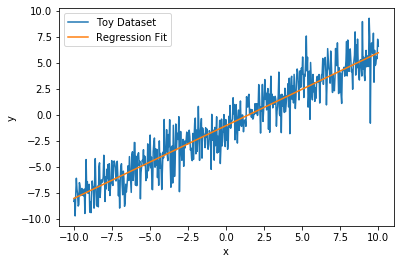

In [12]:
plt.plot(dataset.x.numpy(),dataset.y.numpy(),label="Toy Dataset")
plt.plot(dataset.x.numpy(),y_predictions,label="Regression Fit")
plt.xlabel("x"), plt.ylabel("y")
plt.legend()
plt.show()